# Generative Adversarial Network (GANs)

Generative Adversarial neural Networks (GANs) are a type of neural networks introduces Ian Goodfellow in his 2014 article ["Generative Adversarial Nets"](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf). In GANs two neural networks contest with each other in a zero-sum game, where one network gain is the other network's loss.

Given a training set, the objective of the GAN is to learn how to generate new data with the same statistics as the training set. For example, a GAN trained on photographs can generate new photographs that look at least superficially authentic to human observers, having many realistic characteristics.

This objective is achieved by using two networks, which are called **Generator** and **Discriminator**. The Generator is the network of the GAN which is tasked with generating new data similar to the training data starting from random noise, this with the objective to fool the discriminator with such new data. The task of a Discriminator is to classify an example and judge (discriminate) whether that data is authentic or if it was produced by the generator.


![picture](https://drive.google.com/uc?id=14_jILkGp9tIBeFTwTnRvZOCSWh90kaeX)


The core idea of GANs is based on the "indirect" training of the generator through the discriminator, which itself is also being updated dynamically; this enables the models to learn how to classify and to produce new data in an *unsupervised* manner.

# Nuova sezione

In this exercise we will write a GAN with the task of generating and discriminating images from the MNIST dataset, a large database of handwritten digits commonly used for training various image processing systems.

Let's start by importing all the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pickle
from torch.utils import data as t_data
import torchvision.datasets as datasets  # Since we handle image data we'll need some functionalities of torchvision
from torchvision import transforms

After the necessary imports, let's now load the dataset and write a DataLoader for it.

In [2]:
data_transforms = transforms.Compose([transforms.ToTensor()])  # Used to compose several transforms together

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)  # Importing the MNIST dataset

batch_size=4

# Dataloader for our dataset
dataloader_mnist_train = t_data.DataLoader(mnist_trainset, 
                                           batch_size=batch_size,
                                           shuffle=True
                                           )

Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1591914925853/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Let's now write two helper functions:

1.   *plot_img*, which will be used to plot 28x28 pixels images (belonging to the dataset or generated by the GAN);
2.   *make_some_noise*, which will generate the random noise needed for the generator to work.


In [3]:
# Plots 28x28 pixels images
def plot_img(array,number=None):
    array = array.detach()
    array = array.reshape(28,28)
    
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if number:
        plt.xlabel(number,fontsize='x-large')
    plt.show()

# Generates random noise
def make_some_noise():
    return torch.rand(batch_size,100)

Let's write a *generator* class and create an instance of the generator with **input size 100** and **output size 784** (28*28). For the generator we'll use a sequential model with the following architecture:

![picture](https://drive.google.com/uc?id=1L7BhtEBJ17tfjtPaM3LXsKHSLCJjoXH_)

In [4]:
# Defining generator class
class generator(nn.Module):
    
    # Generator architecture
    def __init__(self, input_size, output_size):
        
        super(generator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(input_size,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,1000),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(1000,800),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(800,output_size)
                                 )
    
    # Forward function
    def forward(self, x):
        x = self.net(x)
        return x


# Instantiating the generator
gen = generator(100,784)

Let's now write a *discriminator* class and create an instance of the discriminator with **input size 784** (which is the size of the images of both the dataset and the discriminator) and **output size 1**. Remember that the discriminator is a binary classifier, so it outputs only values between 0 and 1: values towards 0 denote an image classified as *fake*, while values towards 1 denote an image classified as *real*. For the discriminator we'll use a sequential model with the following architecture:

![picture](https://drive.google.com/uc?id=1cdxrsoK_m40sqk4DGtMJox5F6F_RITrB)

In [5]:
# Defining discriminator class
class discriminator(nn.Module):
    
    def __init__(self, input_size, output_size):
        
        super(discriminator, self).__init__()
        
        self.net = nn.Sequential(
                                 nn.Linear(input_size,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,200),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(200,output_size),
                                 nn.Sigmoid()
                                 )

    # Forward function
    def forward(self, x):
        x = self.net(x)
        return x


# Instantiating the discriminator
dis = discriminator(784,1)

Since the discriminator has only to judge whether the image is real or not (by giving in output either 0 or 1) we can use BCE (Binary Cross-Entropy) as loss function of the GAN.

In [6]:
d_steps = 100  # Training steps done by the discriminator in each epoch 
g_steps = 100  # Training steps done by the generator in each epoch 

# Setting up two criterions for the discriminator: one will be used on real data, one on the generated data
criteriond1 = nn.BCELoss()
optimizerd1 = optim.SGD(dis.parameters(), lr=0.001, momentum=0.9)

criteriond2 = nn.BCELoss()
optimizerd2 = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

printing_steps = 200

epochs = 50  # Training epoch

Let's now set up the training loop.

In [10]:
for epoch in range(100):
    
    if epoch%10==0:
        print(epoch)

    # Training the discriminator
    for d_step in range(d_steps):
        dis.zero_grad()  # Zeroing the gradient
        
        # Training the discriminator on real data
        for inp_real,_ in dataloader_mnist_train:
            inp_real_x = inp_real
            break

        inp_real_x = inp_real_x.reshape(4,784)
        dis_real_out = dis(inp_real_x)
        dis_real_loss = criteriond1(dis_real_out,Variable(torch.ones(batch_size,1)))
        dis_real_loss.backward()

        # Training discriminator on the data produced by the generator
        inp_fake_x_gen = make_some_noise()
        dis_inp_fake_x = gen(inp_fake_x_gen).detach() # Getting a generator output
        dis_fake_out = dis(dis_inp_fake_x)
        dis_fake_loss = criteriond1(dis_fake_out,Variable(torch.zeros(batch_size,1)))
        dis_fake_loss.backward()

        optimizerd1.step()  # Optimization step
        
            
    # Training the generator
    for g_step in range(g_steps):
        gen.zero_grad()  # Zeroing the gradient
        
        # Generating input data for the generator
        gen_inp = make_some_noise() # CODE HERE
        
        # The output of the generator (the generated image) is fed to the discriminator
        gen_out = gen(gen_inp)# CODE HERE
        dis_out_gen_training = dis(gen_out)# CODE HERE

        # Criterion applied on the judgement given by the discriminator on the generated image
        gen_loss = criteriond2(dis_out_gen_training,Variable(torch.ones(batch_size,1)))
        gen_loss.backward()
        
        optimizerd2.step()  # Optimization step

0
10
20
30
40
50
60
70
80
90


Now that we trained the GAN, let's generate both a fake image by giving some random noise to the generator and the label the discriminator has given to such image.

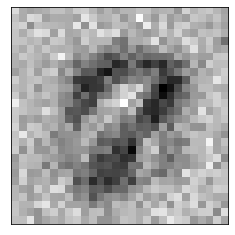

tensor([0.9767], grad_fn=<SigmoidBackward>)


In [11]:
noise1 = make_some_noise()
t1 = gen(noise1)
plot_img(t1[0])
print(dis(t1[0]))